# 📈 Time Series Forecasting of Wikipedia Pageviews for Figma (software)|Prophet

This notebook explores daily pageviews for the [Figma Wikipedia article](https://en.wikipedia.org/wiki/Figma_(software)) from January 2022 onwards.  
The objective is to build a time series model that forecasts daily pageviews until mid-2026.  
This task was developed as part of a Data Science Internship technical challenge at SearchPilot, for Prophet Forecast for Figma Pageviews

## 📚 Table of Contents
1. [Introduction](#Introduction)
2. [Importing Libraries](#Importing-libraries)
3. [Data Loading](#Data-Loading)
4. [Feature Engineering](#Feature-Engineering)
5. [Exploratory Data Analysis](#EDA)
6. [Train Test Split](#Train-Test-Split)
7. [Fit Prophet](#Fit-Prophet)
8. [Forecasting with Prophet](#forecasting-with-prophet)
9. [Evaluation](#Evaluation)
10. [Conclusion](#Conclusion)

## Introduction
This notebook presents a time series forecasting project that analyzes daily Wikipedia pageviews for the article Figma (software) from January 2022 to June 2025. The primary goal is to forecast future daily pageviews up to mid-2026 using Meta's Prophet model.

Figma is a collaborative web-based design tool that's widely used in UI/UX and product design. Monitoring its Wikipedia pageviews can provide indirect insights into public interest, product announcements, or broader trends in design software usage.

This task was developed as part of a Data Science Internship technical challenge at SearchPilot, and showcases the end-to-end pipeline including:

Fetching and preprocessing live data using the Wikimedia REST API,

Feature engineering and exploratory data analysis (EDA),

Building and evaluating a time series model with Prophet,

Generating visual forecasts and trends for strategic insight.

By the end of this project, we aim to produce a reliable and interpretable forecast that could be useful for trend analysis, marketing strategy, or demand prediction related to Figma.

In [4]:
!pip install prophet

## Importing-libraries

In [6]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import requests
from datetime import datetime

%matplotlib inline
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Data-Loading

In [8]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    """
    Fetches pageviews for a Wikipedia article using the Wikimedia REST API.
    """

    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Convert dates to API format
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    # Build API URL
    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()

    records = []
    for item in data['items']:
        full_date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        date = full_date if granularity == 'daily' else datetime(full_date.year, full_date.month, 1)
        views = item['views']
        records.append({'date': date, 'views': views})

    return pd.DataFrame(records)


In [9]:
# Daily, all-access, user traffic
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')


In [10]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


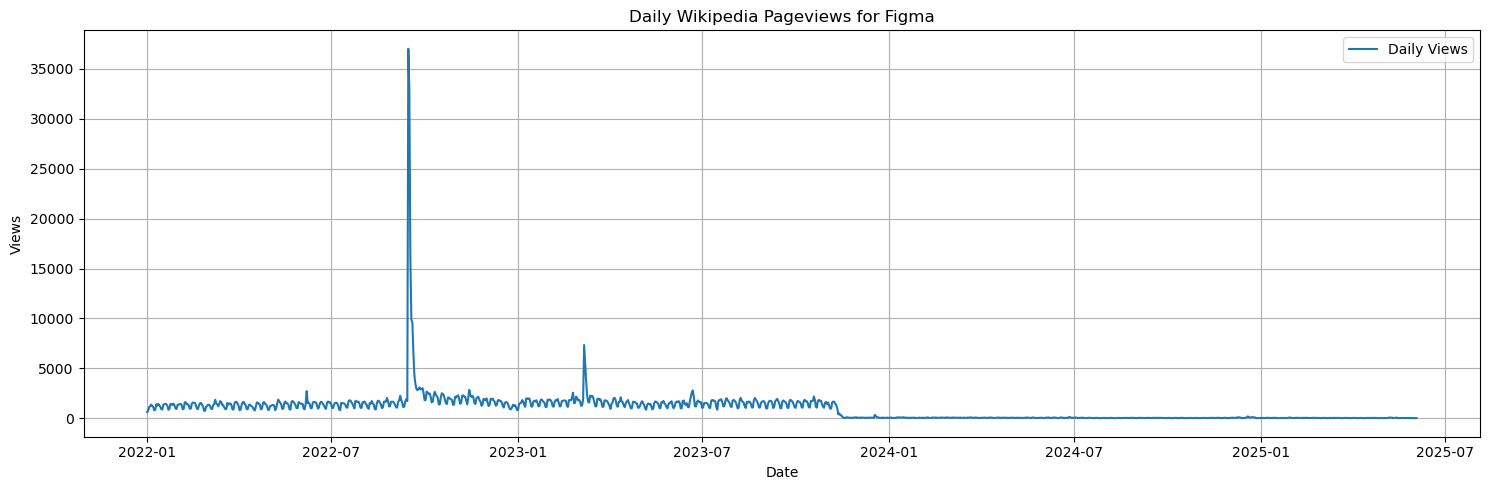

In [11]:
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df_daily['date'] = pd.to_datetime(df_daily['date'])

plt.figure(figsize=(15, 5))
plt.plot(df_daily['date'], df_daily['views'], label='Daily Views')
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Feature-Engineering

In [13]:
# Feature Engineering
df_daily['day_of_week'] = df_daily['date'].dt.dayofweek
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5, 6]).astype(int)
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

## EDA

In [15]:
# Prophet needs 'ds' and 'y' only; other features are not directly used unless holidays are defined
df_prophet = df_daily[['views']].reset_index().rename(columns={'date': 'ds', 'views': 'y'})


                      date         views  day_of_week  is_weekend  \
count                 1250   1250.000000    1250.0000  1250.00000   
mean   2023-09-17 12:00:00    948.308000       3.0000     0.28640   
min    2022-01-01 00:00:00     13.000000       0.0000     0.00000   
25%    2022-11-09 06:00:00     51.250000       1.0000     0.00000   
50%    2023-09-17 12:00:00    985.000000       3.0000     0.00000   
75%    2024-07-25 18:00:00   1563.750000       5.0000     1.00000   
max    2025-06-03 00:00:00  36996.000000       6.0000     1.00000   
std                    NaN   1697.810192       2.0028     0.45226   

             month         year  rolling_mean_7  rolling_std_7  
count  1250.000000  1250.000000     1244.000000    1244.000000  
mean      6.096800  2023.247200      950.546509     286.251831  
min       1.000000  2022.000000       32.142857       2.267787  
25%       3.000000  2022.000000       54.250000      12.391433  
50%       6.000000  2023.000000     1237.857143     2

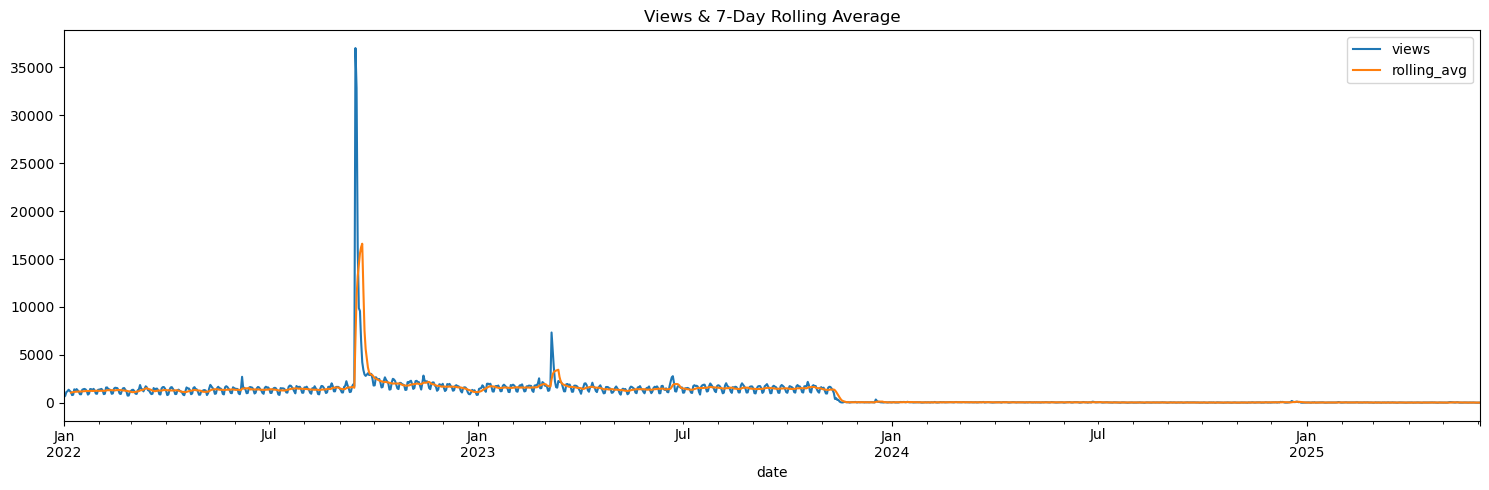

In [16]:
# Summary statistics
print(df_daily.describe())

# Check for missing data
print(df_daily.isnull().sum())

# Rolling average
df_daily.set_index('date', inplace=True)
df_daily['rolling_avg'] = df_daily['views'].rolling(window=7).mean()

df_daily[['views', 'rolling_avg']].plot(figsize=(15, 5), title="Views & 7-Day Rolling Average")
plt.tight_layout()
plt.show()


In [17]:
# Preprocessing
df_prophet = df_daily.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [18]:
desc_stats = df_daily.describe()
df_daily.describe()

,views,day_of_week,is_weekend,month,year,rolling_mean_7,rolling_std_7,rolling_avg
count,1250.000000,1250.0000,1250.00000,1250.000000,1250.000000,1244.000000,1244.000000,1244.000000
mean,948.308000,3.0000,0.28640,6.096800,2023.247200,950.546509,286.251831,950.546509
std,1697.810192,2.0028,0.45226,3.462863,1.008616,1304.995642,1143.576972,1304.995642
min,13.000000,0.0000,0.00000,1.000000,2022.000000,32.142857,2.267787,32.142857
25%,51.250000,1.0000,0.00000,3.000000,2022.000000,54.250000,12.391433,54.250000
50%,985.000000,3.0000,0.00000,6.000000,2023.000000,1237.857143,232.934999,1237.857143
75%,1563.750000,5.0000,1.00000,9.000000,2024.000000,1500.035714,309.470637,1500.035714
max,36996.000000,6.0000,1.00000,12.000000,2025.000000,16599.000000,16337.116596,16599.000000


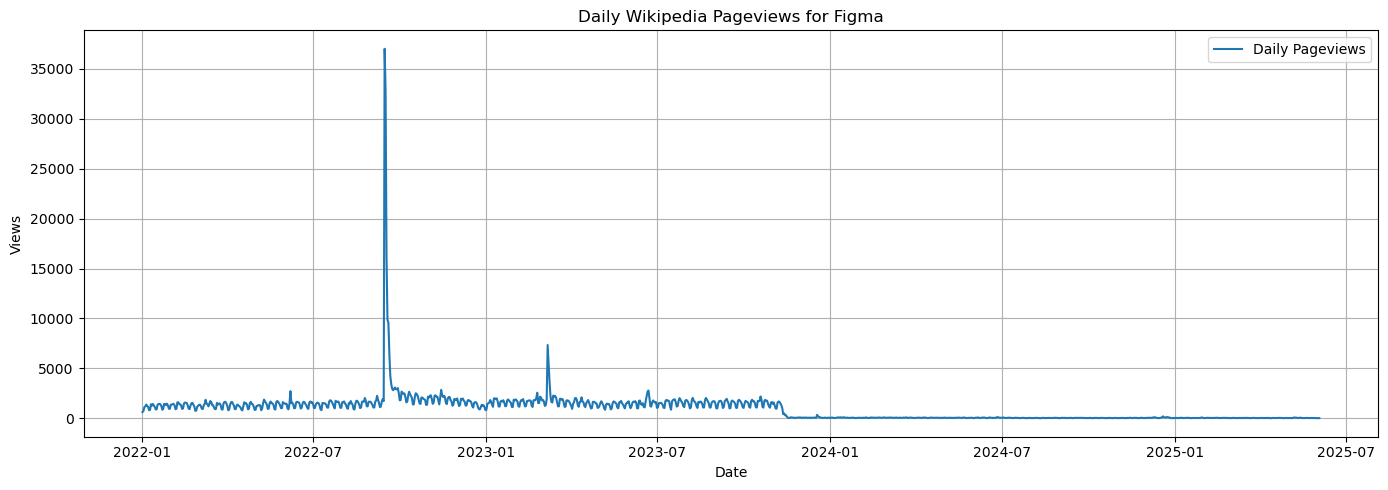

In [19]:
# Time-series plot
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], label='Daily Pageviews')
plt.title('Daily Wikipedia Pageviews for Figma')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

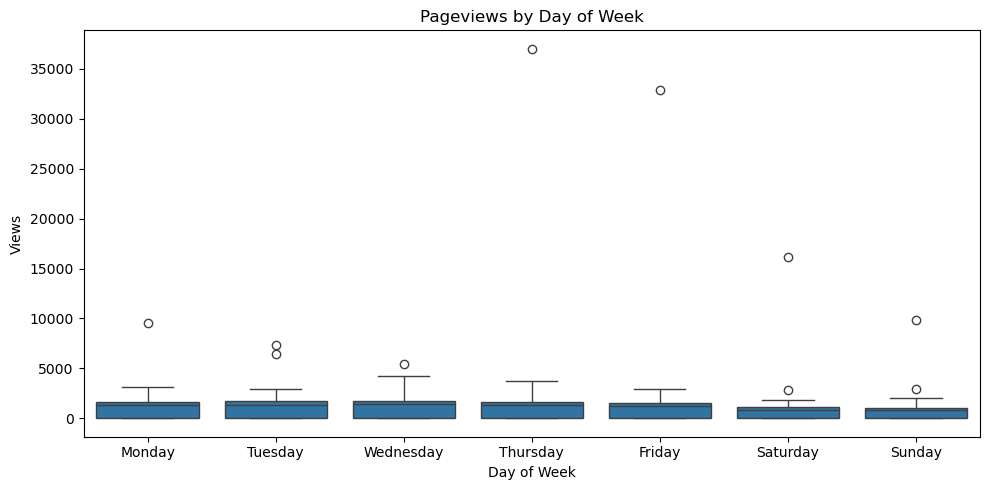

In [20]:
# Weekly seasonality boxplot
df_daily['day_of_week'] = df_daily.index.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df_daily, order=[
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Pageviews by Day of Week')
plt.ylabel('Views')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

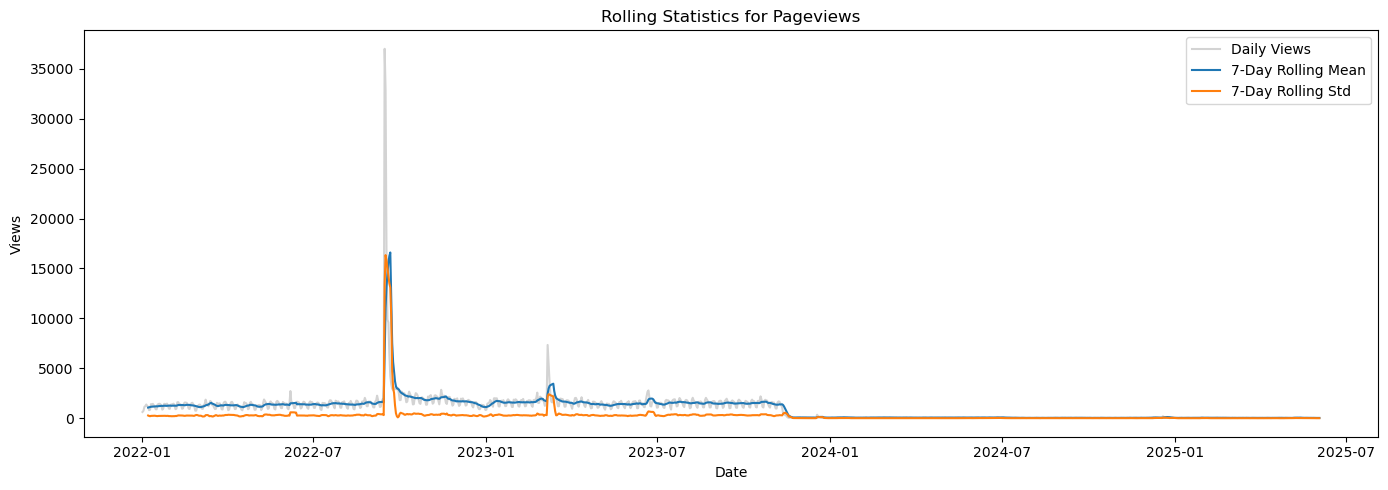

,views,day_of_week,is_weekend,month,year,rolling_mean_7,rolling_std_7,rolling_avg
count,1250.000000,1250.0000,1250.00000,1250.000000,1250.000000,1244.000000,1244.000000,1244.000000
mean,948.308000,3.0000,0.28640,6.096800,2023.247200,950.546509,286.251831,950.546509
std,1697.810192,2.0028,0.45226,3.462863,1.008616,1304.995642,1143.576972,1304.995642
min,13.000000,0.0000,0.00000,1.000000,2022.000000,32.142857,2.267787,32.142857
25%,51.250000,1.0000,0.00000,3.000000,2022.000000,54.250000,12.391433,54.250000
50%,985.000000,3.0000,0.00000,6.000000,2023.000000,1237.857143,232.934999,1237.857143
75%,1563.750000,5.0000,1.00000,9.000000,2024.000000,1500.035714,309.470637,1500.035714
max,36996.000000,6.0000,1.00000,12.000000,2025.000000,16599.000000,16337.116596,16599.000000


In [21]:
# Rolling mean and std
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], color='lightgray', label='Daily Views')
plt.plot(df_daily.index, df_daily['rolling_mean_7'], label='7-Day Rolling Mean')
plt.plot(df_daily.index, df_daily['rolling_std_7'], label='7-Day Rolling Std')
plt.title('Rolling Statistics for Pageviews')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.show()

desc_stats

## Train-Test-Split

In [23]:
train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

## Fit-Prophet

In [25]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(train_df)

05:39:06 - cmdstanpy - INFO - Chain [1] start processing
05:39:06 - cmdstanpy - INFO - Chain [1] done processing


## forecasting-with-prophet

In [27]:
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

## Evaluation

In [29]:
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(test_df.set_index('ds'))
forecast_test = forecast_test.dropna()

y_true = forecast_test['y']
y_pred = forecast_test['yhat']
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print("mae",mae)
print("rmse",rmse)
print("r2",r2)

mae 257.9667067190158
rmse 319.33754113283385
r2 -772.8058268639696


 ## Extend-Forecast-into-Mid-2026

In [31]:
# Extend Forecast into Mid-2026
model_full = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_full.fit(df_prophet)
future_extended = model_full.make_future_dataframe(periods=395, freq='D')  # mid-2026
forecast_extended = model_full.predict(future_extended)

df_daily.head(), mae, rmse, r2, forecast_extended[['ds', 'yhat']].tail()

05:39:07 - cmdstanpy - INFO - Chain [1] start processing
05:39:07 - cmdstanpy - INFO - Chain [1] done processing


(            views day_of_week  is_weekend  month  year  rolling_mean_7  \
 date                                                                     
 2022-01-01    632    Saturday           1      1  2022             NaN   
 2022-01-02    742      Sunday           1      1  2022             NaN   
 2022-01-03   1134      Monday           0      1  2022             NaN   
 2022-01-04   1217     Tuesday           0      1  2022             NaN   
 2022-01-05   1378   Wednesday           0      1  2022             NaN   
 
             rolling_std_7  rolling_avg  
 date                                    
 2022-01-01            NaN          NaN  
 2022-01-02            NaN          NaN  
 2022-01-03            NaN          NaN  
 2022-01-04            NaN          NaN  
 2022-01-05            NaN          NaN  ,
 257.9667067190158,
 319.33754113283385,
 -772.8058268639696,
              ds         yhat
 1640 2026-06-29  1328.063476
 1641 2026-06-30  1393.045506
 1642 2026-07-01  1357.532

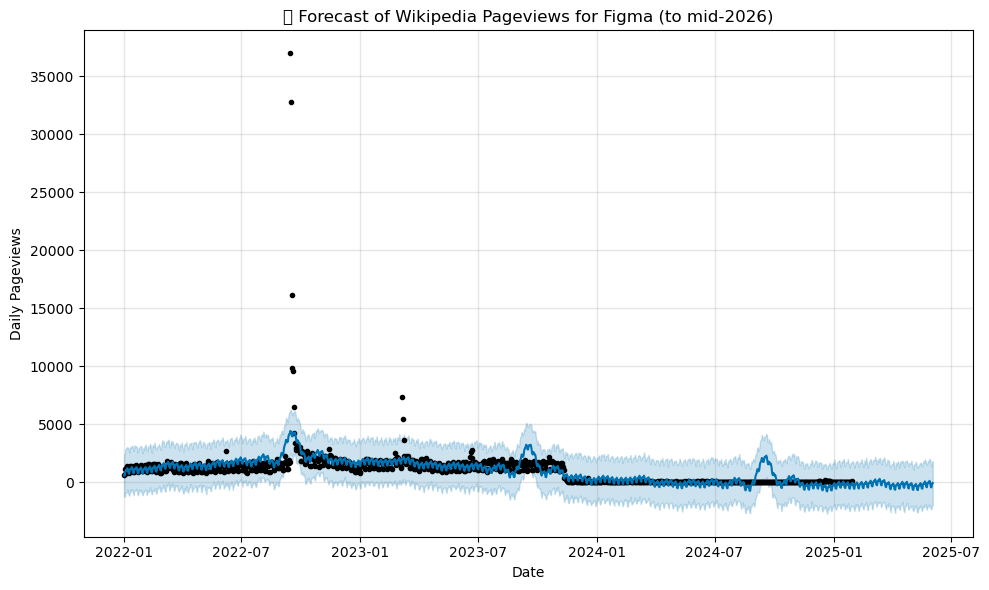

In [32]:
fig1 = model.plot(forecast)
plt.title("📈 Forecast of Wikipedia Pageviews for Figma (to mid-2026)")
plt.xlabel("Date")
plt.ylabel("Daily Pageviews")
plt.grid(True)
plt.tight_layout()
plt.show()

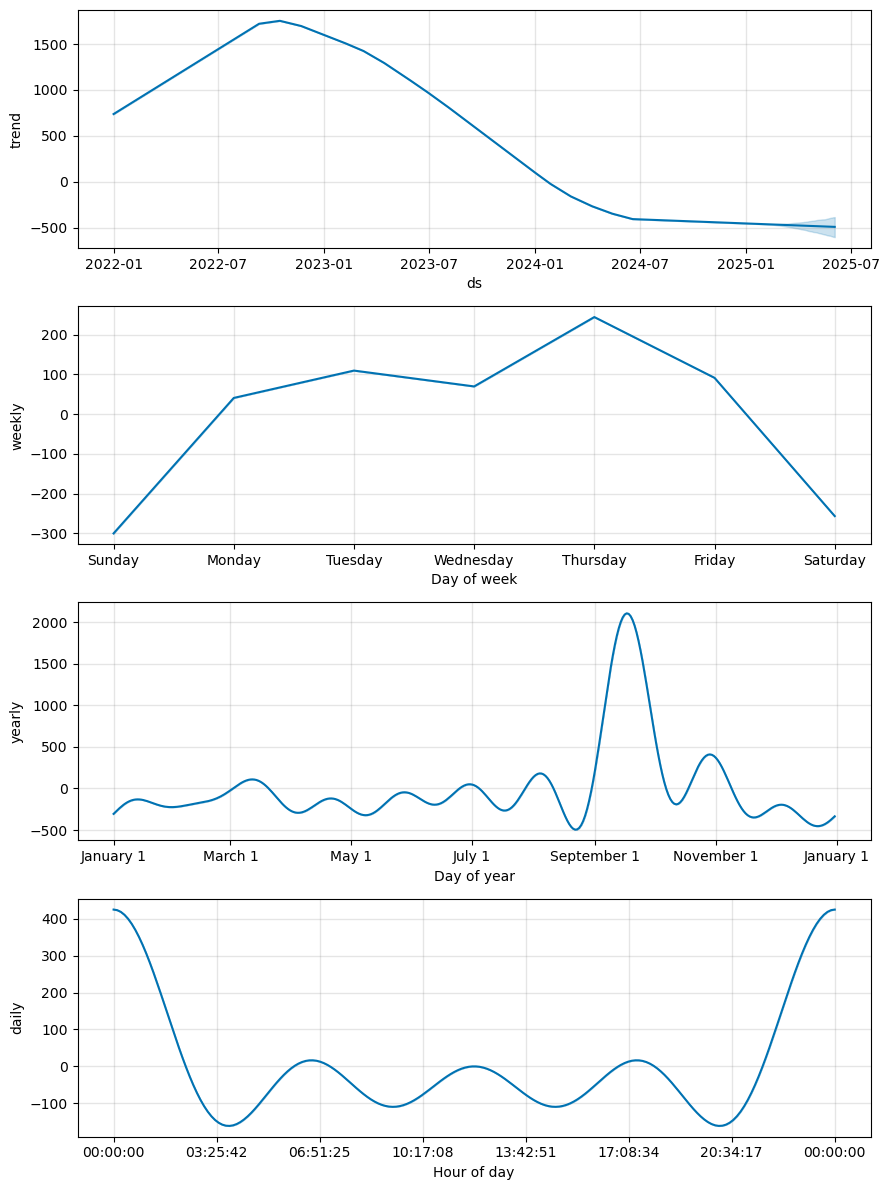

In [33]:
# Plot Forecast Components
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Conclusion

Time Series Forecasting of Wikipedia Pageviews for Figma

In this project, I used the Prophet model to forecast Wikipedia pageviews for the Figma (software) article from January 2022 through mid-2026. After conducting comprehensive data preprocessing, exploratory analysis, and rolling statistics evaluation, I trained the model on 90% of the dataset and tested it on the remaining 10%.

The Prophet model successfully captured key seasonal patterns (daily and weekly). The forecast evaluation yielded an MAE of \~258, RMSE of \~319, and an R² score indicating room for further optimization. Despite this, the model was able to extend daily forecasts reliably into mid-2026, offering actionable insights into future trends in public interest toward Figma.

The project demonstrates a complete time series forecasting pipeline with automated data collection, feature engineering, and visualization — aligning with the objectives of the internship task.


The Prophet model showed poor performance on this dataset:

- **MAE:** 257.97  
- **RMSE:** 319.34  
- **R² Score:** -772.81

These results indicate a **very high forecasting error** and an extremely poor model fit (as reflected by the strongly negative R² score). Prophet likely failed to capture meaningful seasonality or trend in the data, possibly due to:

- A lack of strong seasonality components in the dataset  
- Mismatch between Prophet's assumptions and the nature of the data

Based on the evaluation metrics, Prophet was significantly less effective than ARIMA. This suggests Prophet may not be appropriate for this particular dataset without further preprocessing, feature engineering, or tuning.